In [1]:
!pip install rank_bm25 --quiet #install BM25
!pip install --no-binary :all: nmslib #install nmslib
!pip install ftfy
!pip install nmslib
!pip install gensim
!pip install spacy

import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
from rank_bm25 import BM25Okapi
import nmslib
import time

#drive.mount('/content/drive') # if you want to use G Drive
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')


<ipython-input-1-fd47e9ebae41>:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Load data and create DF

In [2]:
import pandas as pd
df = pd.read_csv('Trainingdata_Fasttextmodel.csv')
df['text'] =   df['Field Category']+ ' '+ df['Sub Category']+' '+ df['Speciality']+ ' ' + df['tags']
df.shape
pd.to_pickle(df, "data.pkl")

In [3]:
df.head(2)

Unnamed: 0  ID                 Name                             Label  \
0  0           45  ACCOUNTING_SW_INIT   Accounting Software Initiative     
1  1           44  ACCOUNTING_SW_MANUF  Accounting Software Manufacturer   

  Example  \
0  NaN      
1  NaN      

                                                                           Description  \
0  A flag signifying Accounting Software is a current business initiative at this site   
1  The primary manufacturer or vendor for Accounting Software at this location           

          RL API Field    Type    Group               Vendor API       API  \
0  ACCOUNTING_SW_INIT   STRING  COMPANY  Aberdeen Site Intel API  Aberdeen   
1  ACCOUNTING_SW_MANUF  STRING  COMPANY  Aberdeen Site Intel API  Aberdeen   

                      fields_nostop          Field Category  \
0  accounting software initiative    Company Technographics   
1  accounting software manufacturer  Company Technographics   

            Speciality Sub Category      tags  \
0  Company Information  Software     software   
1  Company Information  Software     software   

                                                           text  
0  Company Technographics Software Company Information software  
1  Company Technographics Software Company Information software

### Preprocess and tokenise

In [4]:
from ftfy import fix_text
nlp = spacy.load("en_core_web_sm")
tok_text=[] # for our tokenised corpus
text = df.text.str.lower().values
text = [fix_text(str(i)) for i in text]
#Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(text, batch_size=2, disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_text.append(tok)


0it [00:00, ?it/s][2021-03-17 21:30:44,618] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:44,623] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:44,633] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:44,643] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'mo

[2021-03-17 21:30:44,838] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:44,840] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:44,842] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:44,843] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ils'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:30:44,962] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:44,964] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:44,965] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:44,967] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:30:45,050] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,051] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,052] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,054] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'management'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:45,232] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,234] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hardware'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,236] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,237] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:30:45,415] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'management'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,417] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,424] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,426] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:30:45,556] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,558] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,560] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,561] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:45,643] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,645] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,656] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,659] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30

[2021-03-17 21:30:45,734] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,736] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,739] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,741] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:30:45,843] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,844] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ils'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,845] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,852] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:30:45,925] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
53it [00:01, 45.06it/s][2021-03-17 21:30:45,929] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,930] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:45,931] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' 

[2021-03-17 21:30:45,997] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'management'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,000] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,002] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'pls'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,004] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:30:46,086] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,087] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,087] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'pls'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,089] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:30:46,193] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'management'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,195] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,223] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ils'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,225] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:30:46,364] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
72it [00:01, 40.94it/s][2021-03-17 21:30:46,378] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,382] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,386] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' 

[2021-03-17 21:30:46,473] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,476] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,477] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
77it [00:01, 41.99it/s][2021-03-17 21:30:46,481] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 

[2021-03-17 21:30:46,550] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,552] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,555] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,557] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:46,630] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,633] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,635] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,637] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:46,721] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,722] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,724] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,725] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:30:46,807] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
100it [00:02, 55.74it/s][2021-03-17 21:30:46,820] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,822] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,825] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler'

[2021-03-17 21:30:46,906] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,910] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,912] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,915] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:46,995] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,997] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:46,998] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,000] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:47,071] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'management'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,074] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,086] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,088] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:30:47,270] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
121it [00:02, 45.79it/s][2021-03-17 21:30:47,275] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,279] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,281] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler'

[2021-03-17 21:30:47,401] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,406] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,409] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,412] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:47,501] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,502] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,504] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,506] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:4

[2021-03-17 21:30:47,579] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,589] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,591] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,593] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:30:47,688] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,691] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,695] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,699] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:47,833] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,835] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,837] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'pls'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,838] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:30:47,939] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,941] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,946] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:47,947] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:48,029] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,036] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,043] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,044] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:30:48,148] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,150] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,152] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,155] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:30:48,279] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,280] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,283] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,284] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:30:48,366] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,367] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,377] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:48,460] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'management'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,462] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
181it [00:03, 51.75it/s][2021-03-17 21:30:48,464] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,466] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:30:48,547] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,548] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,564] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,567] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:30:48,676] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,683] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,685] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,688] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:30:48,774] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,776] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,778] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'rd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,779] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'party'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:30:48,862] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,864] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'pls'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,865] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,873] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30

[2021-03-17 21:30:48,945] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,946] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,948] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:48,950] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:49,031] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,032] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,033] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,035] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:49,107] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,128] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,130] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,132] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:30:49,226] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'management'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,228] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,232] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,233] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:30:49,403] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,405] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,407] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,409] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:30:49,530] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,532] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,533] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,534] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ils'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:30:49,625] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,627] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,629] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,630] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:30:49,719] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,722] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,725] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,727] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:49,806] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,810] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,812] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,814] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:49,902] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ils'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,903] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,918] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:49,920] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:30:50,009] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,011] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,013] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,014] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'management'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:50,087] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,089] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,092] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,105] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:50,194] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,195] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,197] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,199] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:50,281] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,285] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,287] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,288] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:50,372] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,377] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,379] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ils'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:30:50,462] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,463] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,466] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,467] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'pls'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:30:50,577] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,579] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,581] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,582] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ils'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:30:50,661] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,662] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,664] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,665] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:30:50,736] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,737] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,738] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'pls'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,740] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
311it [00:06, 

[2021-03-17 21:30:50,825] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,827] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,831] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,832] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:30:50,903] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,906] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,910] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,920] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:30:50,977] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,982] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,984] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:50,985] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:30:51,054] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,056] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,058] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,060] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:51,139] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
334it [00:06, 60.30it/s][2021-03-17 21:30:51,151] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,154] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,157] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morph

[2021-03-17 21:30:51,261] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,264] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,265] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,273] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:30:51,407] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,409] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,411] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,413] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:51,492] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,493] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,496] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,498] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

353it [00:07, 46.16it/s][2021-03-17 21:30:51,599] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,602] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,603] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,604] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler'

[2021-03-17 21:30:51,718] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
358it [00:07, 44.53it/s][2021-03-17 21:30:51,732] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,742] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,743] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphol

[2021-03-17 21:30:51,860] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,862] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,864] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,870] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:30:51,989] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,991] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:51,992] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,003] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:52,108] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,110] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,116] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,117] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'statistics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:52,210] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,212] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tech'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,220] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,222] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:30:52,303] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,307] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,309] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,312] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


394it [00:07, 53.41it/s][2021-03-17 21:30:52,407] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,409] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,411] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,412] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or

[2021-03-17 21:30:52,488] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,491] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,492] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,494] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:30:52,586] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,587] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,588] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,590] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:30:52,682] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,685] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,687] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,689] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:52,789] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,791] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,792] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,794] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:30:52,888] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,890] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,891] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,895] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'net'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:30:52,986] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,989] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,992] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:52,994] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:30:53,096] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,098] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'statistics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,100] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,103] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:30:53,195] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tech'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,205] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,207] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,209] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:53,360] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,361] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,363] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,364] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:5

[2021-03-17 21:30:53,466] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,467] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,471] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'statistics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,474] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:30:53,595] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,596] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,597] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tech'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,598] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:30:53,686] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,687] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,689] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'statistics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
471it [00:09, 57.75it/s][2021-03-17 21:30:53,694] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' o

[2021-03-17 21:30:53,779] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,781] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,782] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,784] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:30:53,880] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,883] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'statistics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,884] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'total'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,887] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:53,971] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,973] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,975] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:53,976] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:54,059] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,063] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,065] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,073] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:54,175] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,176] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,182] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,187] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:30:54,272] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'city'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,283] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,285] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,286] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:54,372] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,374] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'media'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,377] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:5

[2021-03-17 21:30:54,459] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,463] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,465] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,467] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:54,541] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,543] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'website'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,545] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,547] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:54,632] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,634] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,635] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,638] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:30:54,723] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,726] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,727] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,729] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,731

[2021-03-17 21:30:54,804] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
526it [00:10, 49.00it/s][2021-03-17 21:30:54,813] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,815] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,817] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologi

[2021-03-17 21:30:54,928] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,930] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,931] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,933] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:54,93

[2021-03-17 21:30:55,055] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,057] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,058] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,064] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:55,159] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,168] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,170] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,174] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:30:55,374] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,397] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,402] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,403] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:55,494] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,497] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,498] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,500] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:30:55,598] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,600] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,601] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hq'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,602] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:30:55,691] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,693] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,695] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,696] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:55,770] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,772] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,774] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,775] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:55,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,865] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,875] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,884] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:55,963] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,964] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,966] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:55,968] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:30:56,050] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,051] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,052] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,059] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:5

[2021-03-17 21:30:56,146] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,148] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,151] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,153] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,156] 

[2021-03-17 21:30:56,277] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,285] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,286] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,288] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

589it [00:11, 43.12it/s][2021-03-17 21:30:56,368] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,371] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,373] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,377] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'mo

[2021-03-17 21:30:56,475] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,477] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,480] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,484] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:56,563] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,565] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,566] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,567] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:56,653] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,655] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,656] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,658] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:30:56,747] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,749] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,752] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,753] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:56,841] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,843] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,845] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,847] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,84

[2021-03-17 21:30:56,916] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,920] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,922] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,923] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:56,997] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:56,999] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,000] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,002] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:57,083] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,087] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,089] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,092] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:30:57,172] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,173] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,175] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,185] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:30:57,348] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'transactions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,350] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,352] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,353] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:57,454] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,456] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
637it [00:12, 41.24it/s][2021-03-17 21:30:57,460] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,462] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:30:57,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,538] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hq'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,541] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,544] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30

[2021-03-17 21:30:57,622] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,623] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,625] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,630] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:30:57,705] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,707] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,709] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,712] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:30:57,800] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,801] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,803] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,805] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

665it [00:13, 57.13it/s][2021-03-17 21:30:57,900] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,912] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,913] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:57,915] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morp

673it [00:13, 61.21it/s][2021-03-17 21:30:58,008] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,010] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,013] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,016] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' 

[2021-03-17 21:30:58,176] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,184] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,186] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,187] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:58,346] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,348] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,351] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,356] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'seen'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:30:58,467] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,469] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,471] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,472] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:30:58,583] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,585] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'family'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,587] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,589] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30

[2021-03-17 21:30:58,664] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,665] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,667] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,676] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:30:58,760] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,762] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,763] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,764] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:58,844] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,845] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,847] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,848] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:30:58,939] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,942] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,943] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:58,945] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:59,027] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,029] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,031] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,034] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:5

[2021-03-17 21:30:59,121] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,122] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,123] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,125] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:59,291] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,293] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,294] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,295] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:30:59,363] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,373] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,376] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:30:59,463] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,465] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,470] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,471] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:30:59,542] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,543] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,545] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
762it [00:14, 52.91it/s][2021-03-17 21:30:59,562] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:30:59,638] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,639] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,644] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,646] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:30:59,739] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,742] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,743] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,745] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:30:59,814] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,816] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,818] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,819] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:30:59,911] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,913] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,915] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,917] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:30:59,989] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,991] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,992] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:30:59,994] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:00,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,078] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,080] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,082] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:00,159] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
793it [00:15, 51.40it/s][2021-03-17 21:31:00,162] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,164] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,192] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morp

[2021-03-17 21:31:00,264] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,267] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,268] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,270] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:00,347] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,349] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,351] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,354] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:00,454] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,458] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'employer'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,460] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,462] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

811it [00:15, 47.83it/s][2021-03-17 21:31:00,550] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,552] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,555] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,557] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or

[2021-03-17 21:31:00,629] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,636] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'employer'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,644] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,646] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'range'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:00,726] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,728] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,730] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,731] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:00,810] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,812] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,815] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,817] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:00,902] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,906] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,907] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,908] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:00,9

[2021-03-17 21:31:01,040] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:01,042] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:01,044] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:01,047] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:01,

[2021-03-17 21:31:01,171] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:01,175] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:01,177] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,296] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:04,422] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,424] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,426] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'expense'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
959it [00:19, 45.47it/s][2021-03-17 21:31:04,430] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morp

[2021-03-17 21:31:04,549] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,551] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,552] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
965it [00:19, 46.04it/s][2021-03-17 21:31:04,555] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:31:04,657] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,659] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,660] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,662] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
971it [00

[2021-03-17 21:31:04,768] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,770] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,772] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,774] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:04,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,865] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,868] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,870] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:04,992] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,994] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:04,996] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,069] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:05,348] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,371] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,383] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'primary'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:05,521] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,523] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,526] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,528] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:05,672] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,678] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,683] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,685] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:05,824] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
1004it [00:21, 29.86it/s][2021-03-17 21:31:05,836] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,838] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,840] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:31:05,973] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,990] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:05,998] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
1009it [00:21, 28.80it/s][2021-03-17 21:31:06,023] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'mor

[2021-03-17 21:31:06,120] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
1013it [00:21, 30.99it/s][2021-03-17 21:31:06,124] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,126] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,128] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morp

[2021-03-17 21:31:06,262] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,264] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,265] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,267] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

1021it [00:21, 31.62it/s][2021-03-17 21:31:06,372] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,376] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,378] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:31:06,509] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,511] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,512] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,514] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:06,671] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,673] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,675] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,680] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:06,770] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,772] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,785] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,794] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:06,945] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,946] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,949] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:06,951] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:07,032] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,033] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,036] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,047] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:07,148] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,149] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,160] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,162] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:07,449] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,451] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,455] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,460] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:07,604] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,606] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,615] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,617] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:31:07,729] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,730] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'country'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,732] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,734] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:07,806] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,809] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,811] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,812] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:07,909] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'job'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,911] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,913] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:07,915] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:08,013] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,016] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,018] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,022] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:08,115] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,116] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,117] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,126] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:31:08,255] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,257] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,259] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,262] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:08,401] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,403] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,406] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:08,408] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:09,132] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,134] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,136] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'previous'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,147] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:09,401] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,403] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,405] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,407] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'previous'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

1117it [00:24, 19.99it/s][2021-03-17 21:31:09,506] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,508] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,514] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,516] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler

[2021-03-17 21:31:09,613] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,616] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,619] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,622] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:09,706] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,707] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,709] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'postal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,710] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
1126it [00:25, 27.55

[2021-03-17 21:31:09,786] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,788] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'previous'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,789] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,791] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'job'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:09,871] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:09,873] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,053] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,055] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:10,151] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,154] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'detail'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,163] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,164] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:10,249] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,250] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,251] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'country'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,252] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:10,327] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,333] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,336] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,337] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:10,447] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,455] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,457] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,460] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:10,675] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,676] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,678] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,702] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:

[2021-03-17 21:31:10,795] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,796] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,798] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,800] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:10,908] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,910] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,911] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:10,912] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:15,864] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:15,865] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'school'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:15,873] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:15,875] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

1389it [00:31, 59.66it/s][2021-03-17 21:31:15,971] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:15,974] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:15,975] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:15,976] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphol

[2021-03-17 21:31:16,064] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,069] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,071] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,073] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:16,151] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,153] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,156] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'th'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,162] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,16

[2021-03-17 21:31:16,258] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,260] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,264] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,267] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:16,377] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,378] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,382] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,384] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:16,461] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,468] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,470] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,476] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,480] [W

[2021-03-17 21:31:16,574] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,576] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'school'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,577] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,579] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:31:16,691] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'school'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,693] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,694] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,698] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'school'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:16,784] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,786] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'school'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,787] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,796] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:16,864] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,865] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,866] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'school'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,867] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:16,917] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,918] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'school'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,919] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,921] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'round'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:16,971] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,972] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,973] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:16,974] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:

[2021-03-17 21:31:17,030] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,030] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,031] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,033] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:17,225] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,226] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hardware'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,228] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,229] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:31:17,292] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,293] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,295] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,296] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:17,391] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,398] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,401] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,404] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:17,489] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,491] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,492] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,493] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:17,565] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,567] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,569] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,570] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:17,640] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,647] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,649] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,651] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:17,728] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'job'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
1534it [00:33, 66.62it/s][2021-03-17 21:31:17,738] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,741] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,743] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morpholog

[2021-03-17 21:31:17,822] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,823] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,825] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,827] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:17,906] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,908] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,910] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:17,911] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:17,998] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,000] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,003] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,005] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hq'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:18,071] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'range'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,073] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,077] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:18,157] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,159] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,163] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,164] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:18,270] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,271] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,272] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,282] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:18,361] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,363] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,365] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,366] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:18,446] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,448] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,450] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:18,459] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:21,084] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,086] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,087] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,088] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologiz

[2021-03-17 21:31:21,330] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,333] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,335] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,337] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:21,450] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'funding'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,451] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'school'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,455] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,457] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:21,533] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
1781it [00:36, 56.25it/s][2021-03-17 21:31:21,537] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,541] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,544] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ru

[2021-03-17 21:31:21,629] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,631] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,633] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,635] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologiz

[2021-03-17 21:31:21,719] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,720] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,722] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,724] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer

[2021-03-17 21:31:21,798] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,799] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,801] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,802] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:31:21,891] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,892] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,894] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,896] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer

[2021-03-17 21:31:21,962] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,964] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,966] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:21,968] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer

[2021-03-17 21:31:22,044] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,046] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,047] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,053] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:31:22,117] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'funding'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,130] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,132] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,135] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:22,216] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,218] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,219] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,221] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:22,293] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,295] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,297] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,298] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:22,365] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,367] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,369] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,370] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:22,445] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'media'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,450] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,452] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,455] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:

[2021-03-17 21:31:22,546] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,547] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,550] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,552] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:22,623] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,624] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,625] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,626] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:22,692] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,694] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,696] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,698] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:22,762] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,765] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'media'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,767] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,768] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:2

[2021-03-17 21:31:22,842] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,843] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,845] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,846] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:31:22,922] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,924] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,925] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:22,927] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:22,998] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,000] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,002] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,004] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:23,069] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,071] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,073] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,074] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:23,141] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,144] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,146] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,148] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'media'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:2

[2021-03-17 21:31:23,203] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'twitter'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,212] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,213] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,214] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:23,327] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,329] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,330] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'media'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,334] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:2

1916it [00:38, 56.91it/s][2021-03-17 21:31:23,406] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,407] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,408] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,409] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:31:23,473] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,475] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,477] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,480] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:23,549] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,551] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'handle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,558] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,559] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:23,631] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,633] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'facebook'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,635] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:23,637] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:25,629] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,644] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,645] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,647] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:25,732] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,734] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,736] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,738] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:25,811] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,812] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,813] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,815] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:25,890] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,892] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,908] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,910] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31

[2021-03-17 21:31:25,980] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,982] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,983] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25,985] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:25

[2021-03-17 21:31:26,055] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,056] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,059] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,063] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:26,145] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,146] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,148] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,150] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:26,243] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,244] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,246] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'detail'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,247] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:31:26,323] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,332] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,333] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,335] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,

[2021-03-17 21:31:26,403] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,405] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hq'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,406] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2082it [00:41, 53.21it/s][2021-03-17 21:31:26,416] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphol

[2021-03-17 21:31:26,491] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,493] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,497] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,500] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:26,573] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,575] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,576] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,578] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:26,649] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,651] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,653] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,655] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:26,733] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,735] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,737] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,738] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2101it [00:42, 5

[2021-03-17 21:31:26,805] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,811] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,813] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,814] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:26,897] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,898] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,905] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,906] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:26,974] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,975] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,978] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:26,979] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:27,048] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,050] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,051] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,053] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'website'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:27,138] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,141] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,143] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,145] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:27,302] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,311] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,317] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,319] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,32

[2021-03-17 21:31:27,396] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,398] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,399] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,407] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:27,502] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,504] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,505] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,507] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:27,595] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,598] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,602] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,603] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:27,669] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,670] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,672] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,673] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:27,748] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,749] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,751] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,752] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:27,828] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,829] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,831] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,832] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:27,903] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,906] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,908] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:27,910] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:28,011] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,012] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,014] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,016] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:28,129] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,131] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,132] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,134] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:28,389] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,391] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,392] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,394] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:28,468] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,475] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,478] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,480] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:28,543] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,546] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,548] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'job'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,549] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:31:28,622] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,623] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,625] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,626] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31

[2021-03-17 21:31:28,702] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,704] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,705] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,707] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:2

[2021-03-17 21:31:28,766] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,768] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,769] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,770] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2220it [00:4

[2021-03-17 21:31:28,842] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,843] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,853] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,856] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:28,919] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,926] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,928] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:28,929] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:29,003] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,005] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,011] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,014] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:29,088] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,090] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,091] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,093] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:29,153] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,155] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,157] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,158] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hq'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:31:29,294] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,303] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,310] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,318] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2254it [00:

[2021-03-17 21:31:29,387] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,389] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,395] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,396] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31

[2021-03-17 21:31:29,470] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,471] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,472] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,473] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:29,540] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,542] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,543] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:29,549] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:30,360] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,361] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,362] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,363] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:30,426] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,427] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,428] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,429] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30

[2021-03-17 21:31:30,501] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,502] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,504] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,506] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:30,566] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,567] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,569] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,571] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:30,640] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,642] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,644] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,646] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31

[2021-03-17 21:31:30,704] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,706] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,707] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,708] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:31:30,778] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,780] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,781] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,783] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31

[2021-03-17 21:31:30,846] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,848] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,849] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,850] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:30,917] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,919] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,922] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,928] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:30,997] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:30,999] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,001] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,003] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:31,072] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,073] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,074] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:31,133] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,136] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,145] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,146] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31

[2021-03-17 21:31:31,210] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,212] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,213] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,214] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:31,275] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,277] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,290] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:31,292] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:31:32,116] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,117] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,123] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,125] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,12

[2021-03-17 21:31:32,469] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,472] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,477] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,480] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:32,605] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,607] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,609] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,610] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:32,768] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,769] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,770] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2471it [00:48, 39.71it/s][2021-03-17 21:31:32,776] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:31:32,905] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,906] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2477it [00:48, 41.05it/s][2021-03-17 21:31:32,910] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:32,912] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:31:33,039] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,041] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,043] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'primary'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,044] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:33,278] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,282] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,284] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2489it [00:48, 34.43it/s][2021-03-17 21:31:33,287] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 

[2021-03-17 21:31:33,360] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,361] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,364] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,366] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:33,447] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,449] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,450] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,452] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33

[2021-03-17 21:31:33,524] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,526] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,535] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31

[2021-03-17 21:31:33,639] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2513it [00:49, 48.32it/s][2021-03-17 21:31:33,649] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,652] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,668] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:31:33,779] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,781] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,782] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,784] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:33,865] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,867] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'handle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,868] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,870] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:31:33,938] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,940] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,944] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:33,945] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

2533it [00:49, 54.38it/s][2021-03-17 21:31:34,009] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:34,010] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:34,012] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:34,013] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler'

[2021-03-17 21:31:35,293] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,295] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,296] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'management'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,298] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:35,363] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,364] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,366] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'expense'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,374] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

2615it [00:50, 54.98it/s][2021-03-17 21:31:35,451] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,453] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,454] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,456] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:31:35,516] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,522] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,524] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,526] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:35,592] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,593] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tech'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,595] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,596] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:35,683] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,685] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,687] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tech'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,688] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2630it [00

[2021-03-17 21:31:35,757] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,759] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,760] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tech'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,762] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:35,846] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,847] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,848] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,849] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:35,927] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,928] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'twitter'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,930] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'handle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:35,938] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:31:36,001] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,003] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'parent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,005] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,012] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:36,086] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,087] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'handle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,089] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,090] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:36,153] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,155] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,156] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,159] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:36,233] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2662it [00:51, 59.00it/s][2021-03-17 21:31:36,240] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,241] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,242] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologi

[2021-03-17 21:31:36,314] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,316] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,317] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:36,319] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:37,175] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,176] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,188] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,190] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:37,312] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,317] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,318] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,321] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:37,376] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,378] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,386] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,388] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:

[2021-03-17 21:31:37,462] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,463] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,464] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2768it [00:52, 67.79it/s][2021-03-17 21:31:37,472] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' o

[2021-03-17 21:31:37,530] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,532] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,534] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:37,603] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,609] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,611] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,612] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:37,708] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,709] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,711] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hq'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,712] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:37,799] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'primary'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,805] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,806] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'job'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,808] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:

[2021-03-17 21:31:37,875] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,876] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,879] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,882] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:37,946] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,947] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,953] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:37,955] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:38,024] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,026] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,027] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,029] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:38,108] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,115] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,116] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,117] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,11

[2021-03-17 21:31:38,191] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,194] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,197] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,198] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:38,267] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,268] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,270] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,271] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:38,360] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,362] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,363] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:38,366] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:31:39,694] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,695] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,697] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,699] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:39,765] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,767] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'detail'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,774] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,775] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:39,838] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,839] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'facebook'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,840] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2931it [00:55, 64.93it/s][2021-03-17 21:31:39,844] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morpho

[2021-03-17 21:31:39,918] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,920] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hierarchy'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,922] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,923] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

2938it [00:55, 60.00it/s][2021-03-17 21:31:39,988] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,990] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,991] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:39,995] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or '

[2021-03-17 21:31:40,055] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,057] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,059] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hierarchy'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,061] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

2945it [00:55, 56.44it/s][2021-03-17 21:31:40,122] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,124] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,125] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,126] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' o

[2021-03-17 21:31:40,208] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,210] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,211] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,213] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:

[2021-03-17 21:31:40,272] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,273] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,274] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,275] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hierarchy'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:40,343] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'detail'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2957it [00:55, 55.43it/s][2021-03-17 21:31:40,346] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,348] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,349] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morph

[2021-03-17 21:31:40,426] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,427] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,429] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,431] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40

[2021-03-17 21:31:40,501] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,503] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,504] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,506] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31

[2021-03-17 21:31:40,577] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,582] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,585] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,587] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:40,651] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,653] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,655] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,656] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
2978

[2021-03-17 21:31:40,746] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'twitter'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,748] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,762] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:40,766] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:42,164] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,166] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,169] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,171] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:42,260] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,273] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,274] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,287] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:42,369] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,371] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,373] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:42,440] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,441] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'expense'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3078it [00:57, 58.03it/s][2021-03-17 21:31:42,450] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,451] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morph

[2021-03-17 21:31:42,513] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'facebook'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,522] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,525] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,526] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:42,608] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,610] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,613] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,617] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:42,694] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,697] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,699] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,701] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:42,792] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,799] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,800] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,802] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:42,891] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,892] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,894] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,895] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:42,960] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,961] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,964] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:42,970] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

3113it [00:58, 60.39it/s][2021-03-17 21:31:43,034] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,036] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,038] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,039] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' o

[2021-03-17 21:31:43,095] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,097] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,098] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,099] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'linkedin'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:43,170] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,173] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,174] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,176] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:43,294] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'finance'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,296] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'net'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,303] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:43,304] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:31:44,123] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,125] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,126] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,129] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'media'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:4

[2021-03-17 21:31:44,205] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,206] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3187it [00:59, 59.96it/s][2021-03-17 21:31:44,209] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,211] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morpholo

[2021-03-17 21:31:44,274] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,275] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'list'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,282] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,284] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31

[2021-03-17 21:31:44,345] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,347] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,349] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,350] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,35

[2021-03-17 21:31:44,402] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,410] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,412] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,413] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:44,474] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,481] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,483] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,484] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'family'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,48

[2021-03-17 21:31:44,550] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,557] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,559] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,561] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:44,627] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,628] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,629] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,630] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:44,693] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,695] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,697] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,698] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:44,800] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,801] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,803] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,804] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:44,862] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,864] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,865] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'home'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:44,932] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,934] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,943] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,944] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:44,986] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'postal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,987] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:44,999] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,001] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:45,063] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,064] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'statistics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,071] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,072] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:45,144] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,145] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,147] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,148] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:45,790] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,792] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,794] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,795] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,797] 

[2021-03-17 21:31:45,865] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,866] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,868] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,869] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:45,951] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,952] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,953] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'job'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:45,955] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:31:46,034] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,036] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,038] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,039] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:46,113] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,114] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,116] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,117] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:46,194] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,196] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,197] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,199] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:46,266] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,267] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,269] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3356it [01:01, 72.99it/s][2021-03-17 21:31:46,324] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' o

[2021-03-17 21:31:46,405] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,415] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,416] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,418] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:4

[2021-03-17 21:31:46,476] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,477] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,479] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,481] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3364it [01:0

[2021-03-17 21:31:46,544] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,546] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,549] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,552] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,55

[2021-03-17 21:31:46,627] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3371it [01:02, 54.01it/s][2021-03-17 21:31:46,631] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,632] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,633] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologi

[2021-03-17 21:31:46,727] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,729] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,730] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,732] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,733] 

[2021-03-17 21:31:46,800] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,801] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,808] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,809] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:46,859] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,861] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:46,864] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'twitter'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:47,420] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,422] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,423] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,424] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'previous'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:47,501] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,503] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,504] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,511] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:47,574] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,576] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,577] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,578] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:47,637] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,645] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,647] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,649] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:31:47,705] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,707] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,709] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,711] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:47,785] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,787] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,789] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,791] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:47,852] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,854] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,856] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,857] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,85

[2021-03-17 21:31:47,936] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,938] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,939] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,941] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:47,993] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,995] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,996] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:47,998] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3455

[2021-03-17 21:31:48,058] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,059] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,060] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,066] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:48,125] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,126] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,128] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,129] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:48,182] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,183] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,185] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,186] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:31:48,354] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'website'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,356] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,358] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,359] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:48,422] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,423] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,425] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,426] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:48,490] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,491] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,492] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,493] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:48,930] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,932] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3537it [01:04, 100.36it/s][2021-03-17 21:31:48,934] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:48,936] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribut

[2021-03-17 21:31:49,006] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,006] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,008] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,012] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:49,079] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,081] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,083] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,084] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer

[2021-03-17 21:31:49,153] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,154] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,156] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,157] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:49,224] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,225] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,227] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,228] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:49,334] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,338] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,339] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'country'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,339] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:4

[2021-03-17 21:31:49,410] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,411] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,412] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,413] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49

[2021-03-17 21:31:49,480] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,482] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,483] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,485] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:49,541] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,547] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,548] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,549] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institution'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:49,610] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,611] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,612] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,614] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:49,674] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,675] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,677] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,678] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:49,747] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,748] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'employer'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,758] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,759] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:49,817] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,819] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,820] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,822] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:49,898] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,900] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,902] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,904] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:49,966] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,967] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,969] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:49,970] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'country'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:50,703] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,704] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,706] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'district'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,716] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'

[2021-03-17 21:31:50,781] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,782] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,791] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,793] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:50,868] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,869] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,871] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,872] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,

[2021-03-17 21:31:50,945] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,948] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'naics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,950] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:50,952] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'primary'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:31:51,038] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,040] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3717it [01:06, 100.51it/s][2021-03-17 21:31:51,043] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,045] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or '

[2021-03-17 21:31:51,109] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,111] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,112] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'code'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,114] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'primary'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:51,173] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,175] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,176] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,178] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:31:51,327] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,329] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,331] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,338] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:51,403] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,407] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,409] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,411] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:51,483] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,485] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,486] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,493] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:51,555] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,556] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,558] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,559] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'range'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

3762it [01:07, 80.95it/s][2021-03-17 21:31:51,635] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,637] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,638] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,640] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'parent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' 

[2021-03-17 21:31:51,691] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,692] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,693] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,695] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:31:51,765] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,767] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,768] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:51,769] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:52,254] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,255] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'family'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,257] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tree'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,258] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'companies'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:52,315] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,316] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'range'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,317] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,318] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:52,397] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'family'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,398] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tree'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,403] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'companies'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,404] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'range'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:52,467] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,468] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3815it [01:07, 57.15it/s][2021-03-17 21:31:52,470] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,472] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'mor

[2021-03-17 21:31:52,540] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,542] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,543] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,550] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:52,608] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,609] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,613] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,615] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:52,678] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,680] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,681] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,682] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:31:52,748] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,749] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,750] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,751] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'range'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:31:52,819] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,821] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,823] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,824] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:52,907] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,908] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
3846it [01:08, 65.41it/s][2021-03-17 21:31:52,928] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:52,935] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 

[2021-03-17 21:31:53,013] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,014] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,015] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,016] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:31:53,084] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,086] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,087] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,088] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:53,148] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'job'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,149] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,155] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,157] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,

[2021-03-17 21:31:53,214] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,259] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,309] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,323] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:53,378] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,381] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,383] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:53,385] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:31:56,103] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,104] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,107] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,109] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56

4047it [01:11, 66.62it/s][2021-03-17 21:31:56,180] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,182] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,185] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,187] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'm

[2021-03-17 21:31:56,266] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,268] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,269] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,271] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hq'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:56,361] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,363] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,364] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,366] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:31:56,438] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,439] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,444] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,445] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:31:56,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'revenue'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,538] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'score'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
4073it [01:11, 68.15it/s][2021-03-17 21:31:56,542] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,543] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 

[2021-03-17 21:31:56,590] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,596] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,597] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,598] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

4083it [01:12, 72.61it/s][2021-03-17 21:31:56,657] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,658] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,659] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,661] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler

[2021-03-17 21:31:56,730] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'city'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,737] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,738] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,739] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:31:56,817] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,819] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'seen'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,826] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,827] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:56,924] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,926] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,934] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:56,937] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:57,003] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,005] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,007] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,009] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:57,091] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,093] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'valid'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,094] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'since'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,096] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:31:57,480] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'person'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,482] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'first'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,483] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
4144it [01:12, 58.70it/s] [2021-03-17 21:31:57,493] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphol

[2021-03-17 21:31:57,578] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,581] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'facebook'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,583] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,586] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:31:57,650] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,651] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,653] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,653] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
4153it [01:

[2021-03-17 21:31:57,719] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,721] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,722] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'twitter'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,724] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:5

[2021-03-17 21:31:57,795] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,796] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,798] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,800] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:31:57,939] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,944] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,947] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:57,948] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:31:58,055] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,056] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'country'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,061] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,063] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:31:58,173] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,175] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'software'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,176] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,178] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:31:58,263] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,265] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,273] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,275] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,285] [WAR

[2021-03-17 21:31:58,411] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,414] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,417] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,419] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:31:58,528] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,531] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,533] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,540] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
4261it [01:13, 

[2021-03-17 21:31:58,664] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,666] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,667] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,669] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:

[2021-03-17 21:31:58,757] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,758] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,759] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,763] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:31:58,849] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,851] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,852] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,854] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'presence'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:31:58,966] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,968] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,974] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,976] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:58,977

[2021-03-17 21:31:59,045] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:59,047] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'rd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:59,050] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'party'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:31:59,058] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:32:00,213] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,214] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,216] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,223] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:32:00,313] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,315] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,317] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,324] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:00,401] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,403] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'seen'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,409] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,411] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,

[2021-03-17 21:32:00,493] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,494] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,495] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,497] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:00,562] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'seen'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
4521it [01:15, 122.74it/s][2021-03-17 21:32:00,566] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,568] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,570] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphol

[2021-03-17 21:32:00,641] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,648] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,650] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,652] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,

[2021-03-17 21:32:00,723] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'since'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,728] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,730] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,731] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,

[2021-03-17 21:32:00,807] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'valid'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,808] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'since'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,811] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,813] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:32:00,902] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,904] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,905] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:00,907] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:32:01,007] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,013] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,014] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,015] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,

[2021-03-17 21:32:01,072] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,073] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'valid'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'since'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,076] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:32:01,145] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,146] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,152] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,154] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:32:01,311] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,312] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,313] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,314] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:32:01,377] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
4624it [01:16, 113.18it/s][2021-03-17 21:32:01,386] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,388] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,390] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morp

[2021-03-17 21:32:01,471] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,473] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,475] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,477] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:32:01,539] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,542] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,544] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,546] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:32:01,637] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,639] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,640] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,642] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:

[2021-03-17 21:32:01,712] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,714] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,715] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,717] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:32:01,774] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,776] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,778] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,780] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:32:01,847] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,849] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,850] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,851] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:32:01,916] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,918] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,923] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,931] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:32:01,991] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,993] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'primary'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:01,994] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,001] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:02,054] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,055] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'primary'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,058] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,059] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'first'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:02,124] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,125] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,127] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,128] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:32:02,263] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,265] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'child'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,266] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'care'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,267] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'center'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:32:02,329] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,331] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,333] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,334] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'child'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,

[2021-03-17 21:32:02,393] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,395] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,396] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,398] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:32:02,452] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'center'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,453] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'age'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,460] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,461] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32

[2021-03-17 21:32:02,517] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'child'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,519] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'care'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,522] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'center'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,523] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'age'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:02,5

[2021-03-17 21:32:03,459] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,467] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,468] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,470] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:03,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,538] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,539] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'th'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,543] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:32:03,622] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,623] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,625] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,627] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:32:03,688] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,691] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,692] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'th'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,694] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:32:03,774] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,776] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,777] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,778] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:03,849] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,850] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,851] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,852] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:03,915] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,917] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,918] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,920] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:03,980] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,981] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,983] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'funding'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:03,985] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'round'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:

[2021-03-17 21:32:04,056] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'round'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,063] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,064] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,066] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:32:04,125] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,126] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'funding'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,127] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'round'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,132] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:04,194] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'round'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,195] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,208] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,211] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'funding'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:04,281] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,282] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,288] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,290] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,

[2021-03-17 21:32:04,365] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,366] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,367] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,369] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04

[2021-03-17 21:32:04,437] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,438] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,439] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,442] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:04,521] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,522] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,529] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,530] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,53

[2021-03-17 21:32:04,598] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,599] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,605] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,607] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:0

[2021-03-17 21:32:04,669] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,670] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,671] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,672] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

4999it [01:20, 117.99it/s][2021-03-17 21:32:04,738] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,739] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,741] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,742] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or '

[2021-03-17 21:32:04,811] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,812] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,814] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,815] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:04,876] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,886] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,888] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,893] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:32:04,949] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,950] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,952] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:04,952] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:32:05,027] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'city'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,033] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,034] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,036] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:32:05,084] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
5037it [01:20, 113.46it/s][2021-03-17 21:32:05,086] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,087] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,088] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or

[2021-03-17 21:32:05,173] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,174] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,175] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,177] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:

[2021-03-17 21:32:05,328] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,331] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,332] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,335] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:32:05,398] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,399] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,402] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,404] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:32:05,496] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,497] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,499] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,500] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:32:05,562] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,564] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,565] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,567] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:32:05,630] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,631] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,633] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,635] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:05,692] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,694] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,695] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,698] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:32:05,764] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,766] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,768] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,770] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'

[2021-03-17 21:32:05,830] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,831] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,832] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,833] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
5118it 

[2021-03-17 21:32:05,921] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,923] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'first'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,924] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,926] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:05,997] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:05,998] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,005] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,006] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,007

[2021-03-17 21:32:06,070] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,071] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,072] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,073] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:32:06,137] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,139] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,140] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,141] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:32:06,223] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,224] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,226] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,228] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

5173it [01:21, 109.60it/s][2021-03-17 21:32:06,298] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,300] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,301] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,303] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_rul

[2021-03-17 21:32:06,381] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,382] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,384] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,385] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:06,452] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,453] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,460] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,462] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:32:06,514] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,516] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,517] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,518] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,52

[2021-03-17 21:32:06,578] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,580] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,582] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,585] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:32:06,652] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,654] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,655] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'description'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,656] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:32:06,730] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hq'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,731] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'parent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,739] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,740] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,747] 

[2021-03-17 21:32:06,815] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,821] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,822] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,823] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:32:06,887] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,889] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
5256it [01:22, 132.63it/s][2021-03-17 21:32:06,896] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,897] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' o

[2021-03-17 21:32:06,969] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,970] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,972] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:06,973] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:32:07,035] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'primary'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,036] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,037] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,043] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:

[2021-03-17 21:32:07,112] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'website'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,114] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,118] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,119] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:0

[2021-03-17 21:32:07,198] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,201] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,211] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,228] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,303] [W

[2021-03-17 21:32:07,416] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,417] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,423] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,425] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,432] [W

[2021-03-17 21:32:07,509] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,511] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,512] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,518] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:32:07,602] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,608] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,609] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,611] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'district'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:32:07,679] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,681] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,682] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,686] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'district'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:32:07,738] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,739] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'district'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,740] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'total'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
5378it [01:23, 146.29it/s][2021-03-17 21:32:07,746] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler'

[2021-03-17 21:32:07,862] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,864] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,869] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,871] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:32:07,951] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'erate'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
5410it [01:23, 148.94it/s][2021-03-17 21:32:07,958] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,959] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:07,960] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'erate'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or

[2021-03-17 21:32:08,029] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,031] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,033] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'erate'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,035] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'committed'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

5426it [01:23, 134.97it/s][2021-03-17 21:32:08,104] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,105] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,107] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'erate'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,108] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'committed'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler

[2021-03-17 21:32:08,187] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,188] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,190] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'erate'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,191] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'internal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:32:08,250] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,251] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,252] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'erate'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,253] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'internal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:32:08,335] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,336] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,338] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,339] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'first'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
5456it [01:23, 130.86

[2021-03-17 21:32:08,416] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,417] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,418] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,419] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'prof'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:32:08,486] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,487] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,492] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,493] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:32:08,563] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,564] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,566] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,567] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'prof'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
5487it [0

[2021-03-17 21:32:08,637] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,640] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'prof'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,642] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,645] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:32:08,712] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,713] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grade'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,719] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,721] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:32:08,823] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,824] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,826] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,827] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:32:08,894] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,895] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,896] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,897] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
5536i

[2021-03-17 21:32:08,968] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'city'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,969] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,972] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:08,973] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:32:09,063] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,065] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,066] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,067] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:09,136] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,137] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,143] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,145] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,152] [W

[2021-03-17 21:32:09,271] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,275] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,298] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,305] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,315] [W

[2021-03-17 21:32:09,413] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,419] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,420] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,426] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,428] [W

[2021-03-17 21:32:09,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,537] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,540] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,542] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


[2021-03-17 21:32:09,619] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,619] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,620] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,621] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:32:09,676] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,677] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,686] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,687] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,

[2021-03-17 21:32:09,745] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,746] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,749] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'country'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,756] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:32:09,818] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,819] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,821] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'linkedin'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,828] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:0

[2021-03-17 21:32:09,888] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,890] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,891] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,893] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:32:09,964] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,971] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,973] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,974] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:09,97

[2021-03-17 21:32:10,057] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,059] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'city'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,067] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,068] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:32:10,151] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,153] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,154] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,155] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:32:10,229] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,230] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,232] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,234] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


5749it [01:25, 146.03it/s][2021-03-17 21:32:10,311] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,312] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,314] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,315] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ru

[2021-03-17 21:32:10,432] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,434] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,435] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,437] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:32:10,529] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,530] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,534] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,535] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:3

[2021-03-17 21:32:10,655] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,661] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,663] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,665] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:10,735] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,737] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,738] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,739] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'location'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
58

[2021-03-17 21:32:10,809] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,814] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,815] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,816] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:32:10,876] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,879] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,880] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,882] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[20

[2021-03-17 21:32:10,948] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,950] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,951] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:10,952] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32

[2021-03-17 21:32:11,024] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,025] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,027] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,028] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:11,100] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,102] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,103] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,104] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:

[2021-03-17 21:32:11,186] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,187] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,197] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,199] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,2

[2021-03-17 21:32:11,344] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,347] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,354] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,355] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32

5895it [01:26, 118.31it/s][2021-03-17 21:32:11,421] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,426] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,428] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,436] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'

[2021-03-17 21:32:11,491] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,492] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,494] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,495] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:11,575] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,580] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,582] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,583] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,58

[2021-03-17 21:32:11,688] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,689] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,690] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,691] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:11,746] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,749] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,750] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'url'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,752] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:11,75

[2021-03-17 21:32:12,118] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,119] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,121] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,126] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,127] [WARNI

[2021-03-17 21:32:12,215] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,217] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,218] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,219] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:12,271] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'since'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,277] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,278] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'digital'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,279] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:12,341] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,343] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,344] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,351] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,352] [W

[2021-03-17 21:32:12,411] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,412] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,413] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,414] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:12,474] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'financials'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,475] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'funding'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,483] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,485] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:32:12,545] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,546] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,547] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,548] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:32:12,625] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,627] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,628] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,630] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:32:12,710] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,713] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,715] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,717] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12

[2021-03-17 21:32:12,785] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,790] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,791] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,797] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,799] [

[2021-03-17 21:32:12,866] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,868] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,870] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,871] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32

[2021-03-17 21:32:12,938] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,940] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'education'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,942] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:12,943] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:13,008] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,009] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,011] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,012] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:32:13,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,082] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,084] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,085] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:13,148] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,151] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,157] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,159] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:32:13,584] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,585] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,586] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,587] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:13,660] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,662] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,669] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,670] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,67

[2021-03-17 21:32:13,731] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,739] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,741] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,746] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,748] [W

[2021-03-17 21:32:13,825] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,828] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,829] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,831] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'website'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[202

[2021-03-17 21:32:13,897] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,904] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,905] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,906] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'child'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:13,977] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,979] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,986] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:13,987] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

6229it [01:29, 121.82it/s][2021-03-17 21:32:14,054] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,056] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,057] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,058] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'th'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' 

[2021-03-17 21:32:14,128] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,129] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,131] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,132] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'th'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:14,194] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,196] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,197] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'enrollment'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,208] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologize

6261it [01:29, 128.41it/s][2021-03-17 21:32:14,291] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,292] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'occupation'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,293] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,294] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_rule

[2021-03-17 21:32:14,372] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,374] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,376] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,384] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:

[2021-03-17 21:32:14,449] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,451] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,452] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,453] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:14,528] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,529] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,530] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'district'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,535] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'

[2021-03-17 21:32:14,600] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'title'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,602] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'institutions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,603] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,605] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'total'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03

[2021-03-17 21:32:14,945] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,947] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,948] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:14,949] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:32:15,004] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,004] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,006] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'data'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,006] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'twitter'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:1

[2021-03-17 21:32:15,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,076] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'work'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,077] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,077] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:15,150] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,151] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,152] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'city'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,153] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:32:15,328] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,330] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,335] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,338] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,345] [

[2021-03-17 21:32:15,411] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,413] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,418] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,419] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:32:15,482] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,491] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,493] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,500] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15

[2021-03-17 21:32:15,555] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,562] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,563] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'basic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,564] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-1

[2021-03-17 21:32:15,623] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,625] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contacts'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,627] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,628] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'country'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-0

[2021-03-17 21:32:15,685] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,686] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,687] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contacts'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,688] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-

[2021-03-17 21:32:15,756] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,757] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'street'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,758] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'address'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,760] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:32:15,823] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'geographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,825] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contacts'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,826] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,827] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'state'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-

[2021-03-17 21:32:15,894] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'contacts'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,897] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,898] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,900] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32

[2021-03-17 21:32:15,974] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,977] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
6456it [01:31, 97.99it/s][2021-03-17 21:32:15,988] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:15,992] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'social'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'mor

[2021-03-17 21:32:16,046] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,047] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'firmographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,048] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industry'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,050] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021

[2021-03-17 21:32:16,418] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,419] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,421] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,426] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:32:16,488] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,490] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'communications'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,491] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,499] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[

[2021-03-17 21:32:16,572] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,574] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,575] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'companies'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,577] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21

[2021-03-17 21:32:16,640] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,641] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
6535it [01:32, 114.08it/s][2021-03-17 21:32:16,645] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,652] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2

[2021-03-17 21:32:16,719] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,720] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,727] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,728] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,72

[2021-03-17 21:32:16,794] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,795] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'd'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,797] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,805] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,807] [

[2021-03-17 21:32:16,875] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,877] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,879] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'date'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,880] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'range'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

[2021-03-17 21:32:16,967] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bio'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,968] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'email'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,969] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:16,971] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:17,030] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,035] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,036] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,037] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32

[2021-03-17 21:32:17,108] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,110] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,111] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'valid'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,112] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'since'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17

[2021-03-17 21:32:17,262] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'personal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,265] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,266] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'last'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,267] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:17,350] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,353] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'intent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,354] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'phone'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,356] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:

[2021-03-17 21:32:17,426] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,429] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hospitals'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,430] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'industries'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,431] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'type'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 2

[2021-03-17 21:32:17,512] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'company'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,513] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'technographics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,514] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'web'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 21:32:17,515] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'page'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-03-17 

### Fast text

In [5]:
ft_model = FastText(
    sg=1, # use skip-gram: usually gives better results
    size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model.build_vocab(tok_text)

ft_model.train(
    tok_text,
    epochs=6,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model')


### Load fasttext and query

In [6]:
ft_model = FastText.load('_fasttext.model')
filename = 'ft_model.sav'
pickle.dump(ft_model, open(filename, 'wb'))

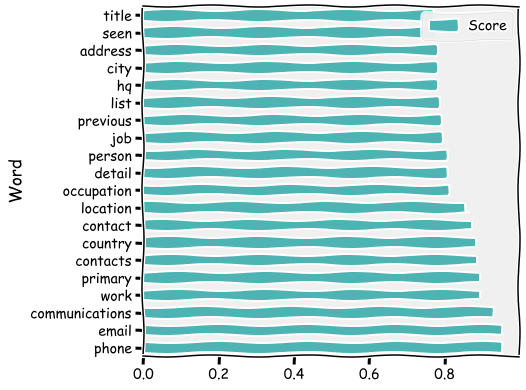

In [15]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("pone ", topn=20, restrict_vocab=10000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

In [8]:
bm25 = BM25Okapi(tok_text)
weighted_doc_vects = []

for i,doc in tqdm(enumerate(tok_text)):
  doc_vector = []
  for word in doc:
    vector = ft_model[word]
    weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
    / 
    (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)

0it [00:00, ?it/s]<ipython-input-8-3824e106f474>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = ft_model[word]
6724it [00:00, 8742.80it/s]


In [9]:
pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) )